In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

/tmp/ipykernel_434411/1226147920.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# # !source activate jupyter_launcher
# !pip3 install numba
# !pip3 install matplotlib
# !pip3 install scipy
# !pip3 install torch
# !pip3 install torchvision
# !pip3 install sklearn
# !pip3 install pycuda
# !pip3 install tqdm
# !pip3 install seaborn
# !pip3 install h5py
# !pip3 install hdfdict
# !pip3 install ipywidgets
# !pip3 install numpy==1.20

In [3]:
import sys
import os
import copy
import pathlib
from pathlib import Path
import time
import gc

In [4]:
from tqdm import tqdm, trange

import numpy as np
import scipy

import torch
import torchvision
import torchvision.transforms as transforms

In [5]:
### Parse arguments

# import sys
# path_script, path_params, dir_save = sys.argv
                
# import json
# with open(path_params, 'r') as f:
#     params = json.load(f)

# import shutil
# shutil.copy2(path_script, str(Path(dir_save) / Path(path_script).name));


# dir_save = '/media/rich/bigSSD/analysis_data/ROI_net_training/testing_dispatcher_20220504'
dir_save = Path(r'/media/rich/bigSSD/')

# params_template = {
params = {
    'paths': {
        'dir_github':'/media/rich/Home_Linux_partition/github_repos',
        'fileName_save_model':'ConvNext_tiny_1.0unfrozen_simCLR',
        'path_data_training':'/media/rich/bigSSD/analysis_data/ROIs_for_training/sf_sparse_36x36_20220503.npz',
    },
    
    'prefs': {
        'saveModelIteratively':True,
        'saveLogs':True,
    },
    
    'useGPU_training': True,
    'useGPU_dataloader': False,
    'dataloader_kwargs':{
        'batch_size': 1024,
        'shuffle': True,
        'drop_last': True,
        'pin_memory': True,
        'num_workers': 36,
        'persistent_workers': True,
        'prefetch_factor': 2,
    },
    'inner_batch_size': 256,

    'torchvision_model': 'convnext_tiny',

    'pre_head_fc_sizes': [256, 128],
    'post_head_fc_sizes': [128],
    'block_to_unfreeze': '7.0',
    'n_block_toInclude': 9,
    'head_nonlinearity': 'GELU',
    
    'lr': 5*10**-3,
    'penalty_orthogonality':0,
    'weight_decay': 0.0000,
    'gamma': 1-0.0000,
    'n_epochs': 9999999,
    'temperature': 0.5,
    'l2_alpha': 0.0000,
    
    'augmentation': {
        'Scale_image_sum': {'sum_val':1, 'epsilon':1e-9, 'min_sub':True},
        'AddPoissonNoise': {'scaler_bounds':(10**(3.5), 10**(4)), 'prob':0.7, 'base':1000, 'scaling':'log'},
        'Horizontal_stripe_scale': {'alpha_min_max':(0.5, 1), 'im_size':(36,36), 'prob':0.3},
        'Horizontal_stripe_shift': {'alpha_min_max':(1  , 2), 'im_size':(36,36), 'prob':0.3},
        'RandomHorizontalFlip': {'p':0.5},
        'RandomAffine': {
            'degrees':(-180,180),
            'translate':(0.1, 0.1), #0, .3, .45 (DEFAULT)
            'scale':(0.6, 1.2), # no scale (1,1), (0.4, 1.5)
            'shear':(-8, 8, -8, 8),
#             'interpolation':torchvision.transforms.InterpolationMode.BILINEAR, 
            'interpolation':'bilinear', 
            'fill':0, 
            'fillcolor':None, 
            'resample':None,
        },
        'AddGaussianNoise': {'mean':0, 'std':0.0010, 'prob':0.5},
        'ScaleDynamicRange': {'scaler_bounds':(0,1), 'epsilon':1e-9},
        'WarpPoints': {
            'r':[0.3, 0.6],
            'cx':[-0.3, 0.3],
            'cy':[-0.3, 0.3], 
            'dx':[-0.24, 0.24], 
            'dy':[-0.24, 0.24], 
            'n_warps':2,
            'prob':0.5,
            'img_size_in':[36, 36],
#             'img_size_out':[72,72],
            'img_size_out':[224,224],
        },
        'TileChannels': {'dim':0, 'n_channels':3},
    },
}

In [6]:
### Import personal libraries

import sys

sys.path.append(params['paths']['dir_github'])

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import torch_helpers, math_functions, classification, h5_handling, plotting_helpers, indexing, misc, decomposition, path_helpers
from GCaMP_ROI_classifier import util, models, training, augmentation, dataset

In [7]:
def write_to_log(path_log, text, mode='a', start_on_new_line=True):
    with open(path_log, mode=mode) as log:
        if start_on_new_line==True:
            log.write('\n')
        log.write(text)

In [8]:
### Prepare paths

path_saveModel = str((dir_save / params['paths']['fileName_save_model']).with_suffix('.pth'))
path_saveLog = str(dir_save / 'log.txt')
path_saveLoss = (dir_save / 'loss.npy')

device_train = torch_helpers.set_device(use_GPU=params['useGPU_training'], verbose=False)

In [9]:
### Import unlabeled training data

import scipy.sparse

sf_sparse = scipy.sparse.load_npz(params['paths']['path_data_training'])

sf_dense = torch.as_tensor(sf_sparse.toarray().reshape(sf_sparse.shape[0], 36,36), dtype=torch.float32)

##toss any NaNs

# print(f'Number of masks: {sf_dense.shape}')
ROIs_without_NaNs = ~torch.any(torch.any(torch.isnan(sf_dense), dim=1), dim=1)
ROIs_nonAllZero = (torch.max(torch.max(sf_dense, dim=1)[0], dim=1)[0] > 0)
ROIs_toKeep = torch.where(ROIs_without_NaNs * ROIs_nonAllZero)[0]
masks_cat = sf_dense[ROIs_toKeep]

n_masks_removed = np.sum(sf_dense.shape[0] - ROIs_toKeep.shape[0])
# print(f'Number of masks: {masks_cat.shape}')

In [10]:
### Define augmentation pipeline

transforms = torch.nn.Sequential(
    *[augmentation.__dict__[key](**params) for key,params in params['augmentation'].items()]
)
scripted_transforms = torch.jit.script(transforms)

device_dataloader = torch_helpers.set_device(use_GPU=params['useGPU_dataloader'])

dataset_train = dataset.dataset_simCLR(
    torch.as_tensor(masks_cat, device=device_dataloader, dtype=torch.float32), 
    torch.as_tensor(torch.zeros(masks_cat.shape[0]), device=device_dataloader, dtype=torch.float32),
    n_transforms=2,
    class_weights=np.array([1]),
    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
    transform=scripted_transforms,
    # DEVICE='cpu',
    DEVICE=device_dataloader,
    dtype_X=torch.float32,
    dtype_y=torch.int64,
    # temp_uncertainty=1
)

dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    **params['dataloader_kwargs']

#     batch_size=1024,
#     shuffle=True,
#     drop_last=True,
#     pin_memory=True,
#     num_workers=36,
#     persistent_workers=True,
#     prefetch_factor=3,
    
#     batch_size=1024,
#     shuffle=False,
#     drop_last=True,
#     pin_memory=False,
#     num_workers=36,
#     persistent_workers=True,
#     prefetch_factor=3,
)

device: 'cpu'


In [11]:
# import matplotlib.pyplot as plt
# %matplotlib notebook

# idx_rand = np.random.randint(0,masks_cat.shape[0], 10)
# for ii in idx_rand:
#     fig, axs = plt.subplots(1,2)
#     # print(dataset_train[ii][0][0][0].shape)
#     axs[0].imshow(dataset_train[ii][0][0][0].cpu())
#     axs[1].imshow(dataset_train[ii][0][1][0].cpu())

In [12]:
### Define ModelTackOn

class ModelTackOn(torch.nn.Module):
    def __init__(
        self, 
        base_model, 
        un_modified_model,
        data_dim=(1,3,36,36), 
        pre_head_fc_sizes=[100], 
        post_head_fc_sizes=[100], 
        classifier_fc_sizes=None, 
        nonlinearity='relu', 
        kwargs_nonlinearity={},
    ):
            super(ModelTackOn, self).__init__()
            self.base_model = base_model
            final_base_layer = list(un_modified_model.children())[-1]
            # final_base_layer = list(list(model.children())[-1].children())[-1]
            # print(final_base_layer)
            
            self.data_dim = data_dim

            self.pre_head_fc_lst = []
            self.post_head_fc_lst = []
            self.classifier_fc_lst = []
                
            self.nonlinearity = nonlinearity
            self.kwargs_nonlinearity = kwargs_nonlinearity

            self.init_prehead(final_base_layer, pre_head_fc_sizes)
            self.init_posthead(pre_head_fc_sizes[-1], post_head_fc_sizes)
            if classifier_fc_sizes is not None:
                self.init_classifier(pre_head_fc_sizes[-1], classifier_fc_sizes)
            
    def init_prehead(self, prv_layer, pre_head_fc_sizes):
        for i, pre_head_fc in enumerate(pre_head_fc_sizes):
            if i == 0:
#                 in_features = prv_layer.in_features if hasattr(prv_layer,'in_features') else 1280
#                 in_features = prv_layer.in_features if hasattr(prv_layer,'in_features') else 960
#                 in_features = prv_layer.in_features if hasattr(prv_layer,'in_features') else 768
#                 in_features = prv_layer.in_features if hasattr(prv_layer,'in_features') else 1536
#                 in_features = prv_layer.in_features if hasattr(prv_layer,'in_features') else 1024
                in_features = self.base_model(torch.rand(*(self.data_dim))).data.squeeze().shape[0]  ## RH EDIT
            else:
                in_features = pre_head_fc_sizes[i - 1]
            fc_layer = torch.nn.Linear(in_features=in_features, out_features=pre_head_fc)
            self.add_module(f'PreHead_{i}', fc_layer)
            self.pre_head_fc_lst.append(fc_layer)

#             if i < len(pre_head_fc_sizes) - 1:
#             non_linearity = torch.nn.ReLU()
#             non_linearity = torch.nn.GELU()
            non_linearity = torch.nn.__dict__[self.nonlinearity](**self.kwargs_nonlinearity)
            self.add_module(f'PreHead_{i}_NonLinearity', non_linearity)
            self.pre_head_fc_lst.append(non_linearity)

    def init_posthead(self, prv_size, post_head_fc_sizes):
        for i, post_head_fc in enumerate(post_head_fc_sizes):
            if i == 0:
                in_features = prv_size
            else:
                in_features = post_head_fc_sizes[i - 1]
            fc_layer = torch.nn.Linear(in_features=in_features, out_features=post_head_fc)
            self.add_module(f'PostHead_{i}', fc_layer)
            self.post_head_fc_lst.append(fc_layer)

#                 non_linearity = torch.nn.ReLU()
#                 non_linearity = torch.nn.GELU()
            non_linearity = torch.nn.__dict__[self.nonlinearity](**self.kwargs_nonlinearity)    
            self.add_module(f'PostHead_{i}_NonLinearity', non_linearity)
            self.pre_head_fc_lst.append(non_linearity)
    
    def init_classifier(self, prv_size, classifier_fc_sizes):
            for i, classifier_fc in enumerate(classifier_fc_sizes):
                if i == 0:
                    in_features = prv_size
                else:
                    in_features = classifier_fc_sizes[i - 1]
            fc_layer = torch.nn.Linear(in_features=in_features, out_features=classifier_fc)
            self.add_module(f'Classifier_{i}', fc_layer)
            self.classifier_fc_lst.append(fc_layer)

    def reinit_classifier(self):
        for i_layer, layer in enumerate(self.classifier_fc_lst):
            layer.reset_parameters()
    
#     def forward(self, X):
#         interim = self.base_model(X)
#         interim = self.get_head(interim)
#         interim = self.get_latent(interim)
#         return interim

    def forward_classifier(self, X):
        interim = self.base_model(X)
        interim = self.get_head(interim)
        interim = self.classify(interim)
        return interim

    def forward_latent(self, X):
        interim = self.base_model(X)
        interim = self.get_head(interim)
        interim = self.get_latent(interim)
        return interim


    def get_head(self, base_out):
        # print('base_out', base_out.shape)
        head = base_out
        for pre_head_layer in self.pre_head_fc_lst:
          # print('pre_head_layer', pre_head_layer.in_features)
          head = pre_head_layer(head)
          # print('head', head.shape)
        return head

    def get_latent(self, head):
        latent = head
        for post_head_layer in self.post_head_fc_lst:
            latent = post_head_layer(latent)
        return latent

    def classify(self, head):
        logit = head
        for classifier_layer in self.classifier_fc_lst:
            logit = classifier_layer(logit)
        return logit

    def set_pre_head_grad(self, requires_grad=True):
        for layer in self.pre_head_fc_lst:
            for param in layer.parameters():
                param.requires_grad = requires_grad
                
    def set_post_head_grad(self, requires_grad=True):
        for layer in self.post_head_fc_lst:
            for param in layer.parameters():
                param.requires_grad = requires_grad

    def set_classifier_grad(self, requires_grad=True):
        for layer in self.classifier_fc_lst:
            for param in layer.parameters():
                param.requires_grad = requires_grad

    def prep_contrast(self):
        self.set_pre_head_grad(requires_grad=True)
        self.set_post_head_grad(requires_grad=True)
        self.set_classifier_grad(requires_grad=False)

    def prep_classifier(self):
        self.set_pre_head_grad(requires_grad=False)
        self.set_post_head_grad(requires_grad=False)
        self.set_classifier_grad(requires_grad=True)

In [13]:
### Import pretrained model

import torchvision.models

# base_model_frozen = torchvision.models.resnet101(pretrained=True)
# base_model_frozen = torchvision.models.resnet18(pretrained=True)
# base_model_frozen = torchvision.models.wide_resnet50_2(pretrained=True)
# base_model_frozen = torchvision.models.resnet50(pretrained=True)

# base_model_frozen = torchvision.models.efficientnet_b0(pretrained=True)

# base_model_frozen = torchvision.models.convnext_tiny(pretrained=True)
# base_model_frozen = torchvision.models.convnext_small(pretrained=True)
# base_model_frozen = torchvision.models.convnext_base(pretrained=True)
# base_model_frozen = torchvision.models.convnext_large(pretrained=True)


# base_model_frozen = torchvision.models.mobilenet_v3_large(pretrained=True)

base_model_frozen = torchvision.models.__dict__[params['torchvision_model']](pretrained=True)

for param in base_model_frozen.parameters():
    param.requires_grad = False

In [14]:
### Make combined model

## Tacking on the latent layers needs to be done in a few steps.

## 0. Chop the base model
## 1. Tack on a pooling layer to reduce the size of the convlutional parameters
## 2. Determine the size of the output (internally done in ModelTackOn)
## 3. Tack on a linear layer of the correct size  (internally done in ModelTackOn)


model_chopped = torch.nn.Sequential(list(base_model_frozen.children())[0][:params['n_block_toInclude']])  ## 0.
model_chopped_pooled = torch.nn.Sequential(model_chopped, torch.nn.AdaptiveAvgPool2d(output_size=1), torch.nn.Flatten())  ## 1.

image_out_size = list(dataset_train[0][0][0].shape)
data_dim = tuple([1] + list(image_out_size))

## 2. , 3.
model = ModelTackOn(
#     model_chopped.to('cpu'),
    model_chopped_pooled.to('cpu'),
    base_model_frozen.to('cpu'),
    data_dim=data_dim,
    pre_head_fc_sizes=params['pre_head_fc_sizes'], 
    post_head_fc_sizes=params['post_head_fc_sizes'], 
    classifier_fc_sizes=None,
    nonlinearity=params['head_nonlinearity'],
    kwargs_nonlinearity={},
)
model.train();

In [15]:
### unfreeze particular blocks in model

mnp = [name for name, param in model.named_parameters()]  ## 'model named parameters'
mnp_blockNums = [name[name.find('.'):name.find('.')+8] for name in mnp]  ## pulls out the numbers just after the model name
mnp_nums = [path_helpers.get_nums_from_string(name) for name in mnp_blockNums]  ## converts them to numbers
block_to_freeze_nums = path_helpers.get_nums_from_string(params['block_to_unfreeze'])  ## converts the input parameter specifying the block to freeze into a number for comparison

m_baseName = mnp[0][:mnp[0].find('.')]

for ii, (name, param) in enumerate(model.named_parameters()):
    if m_baseName in name:
#         print(name)
        if mnp_nums[ii] < block_to_freeze_nums:
            param.requires_grad = False
        elif mnp_nums[ii] >= block_to_freeze_nums:
            param.requires_grad = True

names_layers_requiresGrad = [( param.requires_grad , name ) for name,param in list(model.named_parameters())]

In [16]:
names_layers_requiresGrad

[(False, 'base_model.0.0.0.0.weight'),
 (False, 'base_model.0.0.0.0.bias'),
 (False, 'base_model.0.0.0.1.weight'),
 (False, 'base_model.0.0.0.1.bias'),
 (False, 'base_model.0.0.1.0.layer_scale'),
 (False, 'base_model.0.0.1.0.block.0.weight'),
 (False, 'base_model.0.0.1.0.block.0.bias'),
 (False, 'base_model.0.0.1.0.block.2.weight'),
 (False, 'base_model.0.0.1.0.block.2.bias'),
 (False, 'base_model.0.0.1.0.block.3.weight'),
 (False, 'base_model.0.0.1.0.block.3.bias'),
 (False, 'base_model.0.0.1.0.block.5.weight'),
 (False, 'base_model.0.0.1.0.block.5.bias'),
 (False, 'base_model.0.0.1.1.layer_scale'),
 (False, 'base_model.0.0.1.1.block.0.weight'),
 (False, 'base_model.0.0.1.1.block.0.bias'),
 (False, 'base_model.0.0.1.1.block.2.weight'),
 (False, 'base_model.0.0.1.1.block.2.bias'),
 (False, 'base_model.0.0.1.1.block.3.weight'),
 (False, 'base_model.0.0.1.1.block.3.bias'),
 (False, 'base_model.0.0.1.1.block.5.weight'),
 (False, 'base_model.0.0.1.1.block.5.bias'),
 (False, 'base_model.0.0

In [17]:
### Save run outputs

## The training step is written so that it can run until a job ends, so this needs to be saved before

run_outputs = {
    'dir_save': str(dir_save),    
    'path_save_runOutputs': str(dir_save / 'run_outputs.json'),    
    'path_saveModel': str(path_saveModel),
    'path_saveLog': str(path_saveLog),
    'path_saveLoss': str(path_saveLoss),
    'device_train': device_train,
    'masks_training_shape': list(masks_cat.shape),
    'n_masks_removed': int(n_masks_removed),
    'image_resized_shape': list(dataset_train[0][0][0].shape),
    'names_layers_requiresGrad': names_layers_requiresGrad,
}
run_outputs;

import json
with open(run_outputs['path_save_runOutputs'], 'w') as f:
    json.dump(run_outputs, f) 

In [18]:
### Training

model.to(device_train)
model.prep_contrast()
model.forward = model.forward_latent

from torch.nn import CrossEntropyLoss
from torch.optim import Adam

criterion = [CrossEntropyLoss()]
optimizer = Adam(
    model.parameters(), 
    lr=params['lr'],
#     lr=1*10**-2,
)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                   gamma=params['gamma'],
#                                                    gamma=1,
                                                  )

criterion = [_.to(device_train) for _ in criterion]

In [19]:
losses_train, losses_val = [], [np.nan]
for epoch in tqdm(range(params['n_epochs'])):
    print(f'epoch: {epoch}')
    
    losses_train = training.epoch_step(
        dataloader_train, 
        model, 
        optimizer, 
        criterion,
        scheduler=scheduler,
        temperature=params['temperature'],
        # l2_alpha,
        penalty_orthogonality=params['penalty_orthogonality'],
        mode='semi-supervised',
        loss_rolling_train=losses_train, 
        loss_rolling_val=losses_val,
        device=device_train, 
        inner_batch_size=params['inner_batch_size'],
        verbose=2,
        verbose_update_period=1,

#                                     do_validation=False,
#                                     X_val=x_feed_through_val,
#                                     y_val=torch.as_tensor(y_val, device=DEVICE)
)
    
    ## save loss stuff
    if params['prefs']['saveLogs']:
        write_to_log(path_log=path_saveLog, text=f'time:{time.ctime()}, completed epoch: {epoch}, loss: {losses_train[-1]}, lr: {scheduler.get_last_lr()[0]}')
        np.save(path_saveLoss, losses_train)
    
    ## if loss becomes NaNs, don't save the network and stop training
    if torch.isnan(torch.as_tensor(losses_train[-1])):
        write_to_log(path_log=path_saveLog, text=f'time:{time.ctime()}, EXITED DUE TO loss==NaN')
        break
        
    ## save model
    if params['prefs']['saveModelIteratively']:
        torch.save(model.state_dict(), path_saveModel)

  0%|                                               | 0/9999999 [00:00<?, ?it/s]

epoch: 0
Iter: 0/3021, loss_train: 7.6234, loss_val: nan, pos_over_neg: 1.0014119148254395 lr: 0.005
Iter: 1/3021, loss_train: 7.6995, loss_val: nan, pos_over_neg: 1.0075384378433228 lr: 0.005
Iter: 2/3021, loss_train: 7.6254, loss_val: nan, pos_over_neg: 1.0013622045516968 lr: 0.005
Iter: 3/3021, loss_train: 7.609, loss_val: nan, pos_over_neg: 1.0089548826217651 lr: 0.005
Iter: 4/3021, loss_train: 7.4757, loss_val: nan, pos_over_neg: 1.339573621749878 lr: 0.005
Iter: 5/3021, loss_train: 7.6604, loss_val: nan, pos_over_neg: 0.9991263747215271 lr: 0.005
Iter: 6/3021, loss_train: 7.6107, loss_val: nan, pos_over_neg: 1.0099250078201294 lr: 0.005
Iter: 7/3021, loss_train: 7.6101, loss_val: nan, pos_over_neg: 1.0086206197738647 lr: 0.005
Iter: 8/3021, loss_train: 7.6032, loss_val: nan, pos_over_neg: 1.0129486322402954 lr: 0.005
Iter: 9/3021, loss_train: 7.5149, loss_val: nan, pos_over_neg: 1.0658153295516968 lr: 0.005
Iter: 10/3021, loss_train: 7.3777, loss_val: nan, pos_over_neg: 1.2259445

Iter: 89/3021, loss_train: 6.7717, loss_val: nan, pos_over_neg: 32.65091323852539 lr: 0.005
Iter: 90/3021, loss_train: 6.7887, loss_val: nan, pos_over_neg: 114.59394073486328 lr: 0.005
Iter: 91/3021, loss_train: 6.7763, loss_val: nan, pos_over_neg: 39.343387603759766 lr: 0.005
Iter: 92/3021, loss_train: 6.7788, loss_val: nan, pos_over_neg: 8.511529922485352 lr: 0.005
Iter: 93/3021, loss_train: 6.7341, loss_val: nan, pos_over_neg: 36.150291442871094 lr: 0.005
Iter: 94/3021, loss_train: 6.7606, loss_val: nan, pos_over_neg: 60.49471664428711 lr: 0.005
Iter: 95/3021, loss_train: 6.764, loss_val: nan, pos_over_neg: 180.05670166015625 lr: 0.005
Iter: 96/3021, loss_train: 6.7597, loss_val: nan, pos_over_neg: 114.0985336303711 lr: 0.005
Iter: 97/3021, loss_train: 6.7565, loss_val: nan, pos_over_neg: 20.483449935913086 lr: 0.005
Iter: 98/3021, loss_train: 6.7774, loss_val: nan, pos_over_neg: 25.387393951416016 lr: 0.005
Iter: 99/3021, loss_train: 6.7692, loss_val: nan, pos_over_neg: 65.76619720

Iter: 178/3021, loss_train: 6.5131, loss_val: nan, pos_over_neg: 63.90556335449219 lr: 0.005
Iter: 179/3021, loss_train: 6.4769, loss_val: nan, pos_over_neg: 386.8766784667969 lr: 0.005
Iter: 180/3021, loss_train: 6.505, loss_val: nan, pos_over_neg: 98.10549926757812 lr: 0.005
Iter: 181/3021, loss_train: 6.4876, loss_val: nan, pos_over_neg: 971.7208862304688 lr: 0.005
Iter: 182/3021, loss_train: 6.4815, loss_val: nan, pos_over_neg: 53.3283805847168 lr: 0.005
Iter: 183/3021, loss_train: 6.504, loss_val: nan, pos_over_neg: 124.21345520019531 lr: 0.005
Iter: 184/3021, loss_train: 6.4999, loss_val: nan, pos_over_neg: 51.35084533691406 lr: 0.005
Iter: 185/3021, loss_train: 6.4833, loss_val: nan, pos_over_neg: 84.83181762695312 lr: 0.005
Iter: 186/3021, loss_train: 6.5286, loss_val: nan, pos_over_neg: 62.0367317199707 lr: 0.005
Iter: 187/3021, loss_train: 6.479, loss_val: nan, pos_over_neg: 105.40966033935547 lr: 0.005
Iter: 188/3021, loss_train: 6.4856, loss_val: nan, pos_over_neg: 182.2297

Iter: 266/3021, loss_train: 6.4233, loss_val: nan, pos_over_neg: 79.15790557861328 lr: 0.005
Iter: 267/3021, loss_train: 6.4266, loss_val: nan, pos_over_neg: 115.12944793701172 lr: 0.005
Iter: 268/3021, loss_train: 6.4255, loss_val: nan, pos_over_neg: 346.2503967285156 lr: 0.005
Iter: 269/3021, loss_train: 6.4117, loss_val: nan, pos_over_neg: 95.34675598144531 lr: 0.005
Iter: 270/3021, loss_train: 6.4208, loss_val: nan, pos_over_neg: 53.95091247558594 lr: 0.005
Iter: 271/3021, loss_train: 6.4006, loss_val: nan, pos_over_neg: 206.87330627441406 lr: 0.005
Iter: 272/3021, loss_train: 6.3857, loss_val: nan, pos_over_neg: -1386.2283935546875 lr: 0.005
Iter: 273/3021, loss_train: 6.4192, loss_val: nan, pos_over_neg: 159.6041717529297 lr: 0.005
Iter: 274/3021, loss_train: 6.4022, loss_val: nan, pos_over_neg: 89.94294738769531 lr: 0.005
Iter: 275/3021, loss_train: 6.4233, loss_val: nan, pos_over_neg: 56.7406120300293 lr: 0.005
Iter: 276/3021, loss_train: 6.4085, loss_val: nan, pos_over_neg: 38

Iter: 355/3021, loss_train: 6.3442, loss_val: nan, pos_over_neg: 89.98515319824219 lr: 0.005
Iter: 356/3021, loss_train: 6.3671, loss_val: nan, pos_over_neg: 72.8331298828125 lr: 0.005
Iter: 357/3021, loss_train: 6.3808, loss_val: nan, pos_over_neg: 49.53177261352539 lr: 0.005
Iter: 358/3021, loss_train: 6.3899, loss_val: nan, pos_over_neg: 116.06730651855469 lr: 0.005
Iter: 359/3021, loss_train: 6.3935, loss_val: nan, pos_over_neg: 107.86182403564453 lr: 0.005
Iter: 360/3021, loss_train: 6.3969, loss_val: nan, pos_over_neg: 99.0728988647461 lr: 0.005
Iter: 361/3021, loss_train: 6.377, loss_val: nan, pos_over_neg: 179.530029296875 lr: 0.005
Iter: 362/3021, loss_train: 6.3456, loss_val: nan, pos_over_neg: 89.26646423339844 lr: 0.005
Iter: 363/3021, loss_train: 6.3951, loss_val: nan, pos_over_neg: 69.73420715332031 lr: 0.005
Iter: 364/3021, loss_train: 6.3477, loss_val: nan, pos_over_neg: 462.7091369628906 lr: 0.005
Iter: 365/3021, loss_train: 6.3776, loss_val: nan, pos_over_neg: 63.8835

Iter: 444/3021, loss_train: 6.3496, loss_val: nan, pos_over_neg: 67.2026138305664 lr: 0.005
Iter: 445/3021, loss_train: 6.3572, loss_val: nan, pos_over_neg: 91.3141860961914 lr: 0.005
Iter: 446/3021, loss_train: 6.3493, loss_val: nan, pos_over_neg: 89.88750457763672 lr: 0.005
Iter: 447/3021, loss_train: 6.3251, loss_val: nan, pos_over_neg: 119.20319366455078 lr: 0.005
Iter: 448/3021, loss_train: 6.3714, loss_val: nan, pos_over_neg: 99.38732147216797 lr: 0.005
Iter: 449/3021, loss_train: 6.3542, loss_val: nan, pos_over_neg: 59.13113021850586 lr: 0.005
Iter: 450/3021, loss_train: 6.3409, loss_val: nan, pos_over_neg: 80.0784912109375 lr: 0.005
Iter: 451/3021, loss_train: 6.3354, loss_val: nan, pos_over_neg: 219.1938934326172 lr: 0.005
Iter: 452/3021, loss_train: 6.3362, loss_val: nan, pos_over_neg: 155.7281494140625 lr: 0.005
Iter: 453/3021, loss_train: 6.3629, loss_val: nan, pos_over_neg: 101.44275665283203 lr: 0.005
Iter: 454/3021, loss_train: 6.3438, loss_val: nan, pos_over_neg: 63.249

Iter: 532/3021, loss_train: 6.3461, loss_val: nan, pos_over_neg: 62.94941329956055 lr: 0.005
Iter: 533/3021, loss_train: 6.3331, loss_val: nan, pos_over_neg: 88.73111724853516 lr: 0.005
Iter: 534/3021, loss_train: 6.3258, loss_val: nan, pos_over_neg: 70.66184997558594 lr: 0.005
Iter: 535/3021, loss_train: 6.3294, loss_val: nan, pos_over_neg: 97.19295501708984 lr: 0.005
Iter: 536/3021, loss_train: 6.3126, loss_val: nan, pos_over_neg: 120.19790649414062 lr: 0.005
Iter: 537/3021, loss_train: 6.3431, loss_val: nan, pos_over_neg: 102.668212890625 lr: 0.005
Iter: 538/3021, loss_train: 6.3082, loss_val: nan, pos_over_neg: 133.54542541503906 lr: 0.005
Iter: 539/3021, loss_train: 6.3269, loss_val: nan, pos_over_neg: 198.21746826171875 lr: 0.005
Iter: 540/3021, loss_train: 6.3325, loss_val: nan, pos_over_neg: 91.00950622558594 lr: 0.005
Iter: 541/3021, loss_train: 6.3281, loss_val: nan, pos_over_neg: 167.3179168701172 lr: 0.005
Iter: 542/3021, loss_train: 6.3103, loss_val: nan, pos_over_neg: 69.

Iter: 621/3021, loss_train: 6.3214, loss_val: nan, pos_over_neg: 50.50701904296875 lr: 0.005
Iter: 622/3021, loss_train: 6.304, loss_val: nan, pos_over_neg: 61.79481506347656 lr: 0.005
Iter: 623/3021, loss_train: 6.3327, loss_val: nan, pos_over_neg: 93.8223876953125 lr: 0.005
Iter: 624/3021, loss_train: 6.3052, loss_val: nan, pos_over_neg: 202.20997619628906 lr: 0.005
Iter: 625/3021, loss_train: 6.3052, loss_val: nan, pos_over_neg: 167.16868591308594 lr: 0.005
Iter: 626/3021, loss_train: 6.2962, loss_val: nan, pos_over_neg: 141.59176635742188 lr: 0.005
Iter: 627/3021, loss_train: 6.3215, loss_val: nan, pos_over_neg: 99.16981506347656 lr: 0.005
Iter: 628/3021, loss_train: 6.3178, loss_val: nan, pos_over_neg: 153.67282104492188 lr: 0.005
Iter: 629/3021, loss_train: 6.3255, loss_val: nan, pos_over_neg: 115.76261138916016 lr: 0.005
Iter: 630/3021, loss_train: 6.3078, loss_val: nan, pos_over_neg: 137.94686889648438 lr: 0.005
Iter: 631/3021, loss_train: 6.2983, loss_val: nan, pos_over_neg: 8

Iter: 709/3021, loss_train: 6.2984, loss_val: nan, pos_over_neg: 119.6467056274414 lr: 0.005
Iter: 710/3021, loss_train: 6.3036, loss_val: nan, pos_over_neg: 105.5390396118164 lr: 0.005
Iter: 711/3021, loss_train: 6.3098, loss_val: nan, pos_over_neg: 131.21339416503906 lr: 0.005
Iter: 712/3021, loss_train: 6.3025, loss_val: nan, pos_over_neg: 56.01893997192383 lr: 0.005
Iter: 713/3021, loss_train: 6.3146, loss_val: nan, pos_over_neg: 142.53297424316406 lr: 0.005
Iter: 714/3021, loss_train: 6.2842, loss_val: nan, pos_over_neg: 94.65936279296875 lr: 0.005
Iter: 715/3021, loss_train: 6.3119, loss_val: nan, pos_over_neg: 57.44915771484375 lr: 0.005
Iter: 716/3021, loss_train: 6.2988, loss_val: nan, pos_over_neg: 124.96500396728516 lr: 0.005
Iter: 717/3021, loss_train: 6.2908, loss_val: nan, pos_over_neg: 144.19142150878906 lr: 0.005
Iter: 718/3021, loss_train: 6.2882, loss_val: nan, pos_over_neg: 92.90576934814453 lr: 0.005
Iter: 719/3021, loss_train: 6.2884, loss_val: nan, pos_over_neg: 8

Iter: 797/3021, loss_train: 6.279, loss_val: nan, pos_over_neg: 154.62081909179688 lr: 0.005
Iter: 798/3021, loss_train: 6.2992, loss_val: nan, pos_over_neg: 245.78799438476562 lr: 0.005
Iter: 799/3021, loss_train: 6.2818, loss_val: nan, pos_over_neg: 158.4241180419922 lr: 0.005
Iter: 800/3021, loss_train: 6.2864, loss_val: nan, pos_over_neg: 211.75567626953125 lr: 0.005
Iter: 801/3021, loss_train: 6.2826, loss_val: nan, pos_over_neg: 124.36685180664062 lr: 0.005
Iter: 802/3021, loss_train: 6.2856, loss_val: nan, pos_over_neg: 91.87491607666016 lr: 0.005
Iter: 803/3021, loss_train: 6.2892, loss_val: nan, pos_over_neg: 113.01871490478516 lr: 0.005
Iter: 804/3021, loss_train: 6.297, loss_val: nan, pos_over_neg: 106.6989517211914 lr: 0.005
Iter: 805/3021, loss_train: 6.2957, loss_val: nan, pos_over_neg: 89.10038757324219 lr: 0.005
Iter: 806/3021, loss_train: 6.2905, loss_val: nan, pos_over_neg: 152.07247924804688 lr: 0.005
Iter: 807/3021, loss_train: 6.3167, loss_val: nan, pos_over_neg: 1

Iter: 885/3021, loss_train: 6.2848, loss_val: nan, pos_over_neg: 242.56011962890625 lr: 0.005
Iter: 886/3021, loss_train: 6.2972, loss_val: nan, pos_over_neg: 139.40171813964844 lr: 0.005
Iter: 887/3021, loss_train: 6.2709, loss_val: nan, pos_over_neg: 130.19593811035156 lr: 0.005
Iter: 888/3021, loss_train: 6.3037, loss_val: nan, pos_over_neg: 73.02884674072266 lr: 0.005
Iter: 889/3021, loss_train: 6.2646, loss_val: nan, pos_over_neg: 170.87576293945312 lr: 0.005
Iter: 890/3021, loss_train: 6.2579, loss_val: nan, pos_over_neg: 100.60957336425781 lr: 0.005
Iter: 891/3021, loss_train: 6.2749, loss_val: nan, pos_over_neg: 85.83760070800781 lr: 0.005
Iter: 892/3021, loss_train: 6.2663, loss_val: nan, pos_over_neg: 149.35250854492188 lr: 0.005
Iter: 893/3021, loss_train: 6.2778, loss_val: nan, pos_over_neg: 120.78568267822266 lr: 0.005
Iter: 894/3021, loss_train: 6.2769, loss_val: nan, pos_over_neg: 98.6301498413086 lr: 0.005
Iter: 895/3021, loss_train: 6.297, loss_val: nan, pos_over_neg: 

Iter: 974/3021, loss_train: 6.2873, loss_val: nan, pos_over_neg: 254.97959899902344 lr: 0.005
Iter: 975/3021, loss_train: 6.2894, loss_val: nan, pos_over_neg: 152.07350158691406 lr: 0.005
Iter: 976/3021, loss_train: 6.2815, loss_val: nan, pos_over_neg: 127.6329345703125 lr: 0.005
Iter: 977/3021, loss_train: 6.3073, loss_val: nan, pos_over_neg: 61.443077087402344 lr: 0.005
Iter: 978/3021, loss_train: 6.3056, loss_val: nan, pos_over_neg: 73.32454681396484 lr: 0.005
Iter: 979/3021, loss_train: 6.2832, loss_val: nan, pos_over_neg: 344.80859375 lr: 0.005
Iter: 980/3021, loss_train: 6.2932, loss_val: nan, pos_over_neg: 179.4586639404297 lr: 0.005
Iter: 981/3021, loss_train: 6.2865, loss_val: nan, pos_over_neg: 218.37872314453125 lr: 0.005
Iter: 982/3021, loss_train: 6.2944, loss_val: nan, pos_over_neg: 128.86740112304688 lr: 0.005
Iter: 983/3021, loss_train: 6.27, loss_val: nan, pos_over_neg: 76.35545349121094 lr: 0.005
Iter: 984/3021, loss_train: 6.2907, loss_val: nan, pos_over_neg: 59.5967

Iter: 1062/3021, loss_train: 6.272, loss_val: nan, pos_over_neg: 237.78390502929688 lr: 0.005
Iter: 1063/3021, loss_train: 6.3093, loss_val: nan, pos_over_neg: 47.1288948059082 lr: 0.005
Iter: 1064/3021, loss_train: 6.2824, loss_val: nan, pos_over_neg: 101.78972625732422 lr: 0.005
Iter: 1065/3021, loss_train: 6.2716, loss_val: nan, pos_over_neg: 128.71994018554688 lr: 0.005
Iter: 1066/3021, loss_train: 6.2659, loss_val: nan, pos_over_neg: 122.39649963378906 lr: 0.005
Iter: 1067/3021, loss_train: 6.2703, loss_val: nan, pos_over_neg: 128.65771484375 lr: 0.005
Iter: 1068/3021, loss_train: 6.2832, loss_val: nan, pos_over_neg: 79.14089965820312 lr: 0.005
Iter: 1069/3021, loss_train: 6.2802, loss_val: nan, pos_over_neg: 92.11673736572266 lr: 0.005
Iter: 1070/3021, loss_train: 6.2545, loss_val: nan, pos_over_neg: 173.0022430419922 lr: 0.005
Iter: 1071/3021, loss_train: 6.2919, loss_val: nan, pos_over_neg: 79.19329833984375 lr: 0.005
Iter: 1072/3021, loss_train: 6.2853, loss_val: nan, pos_over

Iter: 1149/3021, loss_train: 6.2681, loss_val: nan, pos_over_neg: 121.47854614257812 lr: 0.005
Iter: 1150/3021, loss_train: 6.2954, loss_val: nan, pos_over_neg: 75.37818145751953 lr: 0.005
Iter: 1151/3021, loss_train: 6.2945, loss_val: nan, pos_over_neg: 62.89112091064453 lr: 0.005
Iter: 1152/3021, loss_train: 6.2899, loss_val: nan, pos_over_neg: 75.99010467529297 lr: 0.005
Iter: 1153/3021, loss_train: 6.2596, loss_val: nan, pos_over_neg: 197.6171417236328 lr: 0.005
Iter: 1154/3021, loss_train: 6.2923, loss_val: nan, pos_over_neg: 184.2664794921875 lr: 0.005
Iter: 1155/3021, loss_train: 6.2615, loss_val: nan, pos_over_neg: 311.0918273925781 lr: 0.005
Iter: 1156/3021, loss_train: 6.2682, loss_val: nan, pos_over_neg: 176.8403778076172 lr: 0.005
Iter: 1157/3021, loss_train: 6.2835, loss_val: nan, pos_over_neg: 61.278106689453125 lr: 0.005
Iter: 1158/3021, loss_train: 6.2803, loss_val: nan, pos_over_neg: 59.32371520996094 lr: 0.005
Iter: 1159/3021, loss_train: 6.271, loss_val: nan, pos_ove

Iter: 1236/3021, loss_train: 6.2811, loss_val: nan, pos_over_neg: 139.5470733642578 lr: 0.005
Iter: 1237/3021, loss_train: 6.2518, loss_val: nan, pos_over_neg: 186.1685028076172 lr: 0.005
Iter: 1238/3021, loss_train: 6.2608, loss_val: nan, pos_over_neg: 183.06036376953125 lr: 0.005
Iter: 1239/3021, loss_train: 6.2759, loss_val: nan, pos_over_neg: 139.87921142578125 lr: 0.005
Iter: 1240/3021, loss_train: 6.291, loss_val: nan, pos_over_neg: 121.73664093017578 lr: 0.005
Iter: 1241/3021, loss_train: 6.2713, loss_val: nan, pos_over_neg: 229.9630126953125 lr: 0.005
Iter: 1242/3021, loss_train: 6.263, loss_val: nan, pos_over_neg: 88.5346450805664 lr: 0.005
Iter: 1243/3021, loss_train: 6.2739, loss_val: nan, pos_over_neg: 105.87476348876953 lr: 0.005
Iter: 1244/3021, loss_train: 6.2851, loss_val: nan, pos_over_neg: 93.5336685180664 lr: 0.005
Iter: 1245/3021, loss_train: 6.2296, loss_val: nan, pos_over_neg: 353.6915283203125 lr: 0.005
Iter: 1246/3021, loss_train: 6.2721, loss_val: nan, pos_over

Iter: 1323/3021, loss_train: 6.2531, loss_val: nan, pos_over_neg: 139.21603393554688 lr: 0.005
Iter: 1324/3021, loss_train: 6.2525, loss_val: nan, pos_over_neg: 140.84307861328125 lr: 0.005
Iter: 1325/3021, loss_train: 6.245, loss_val: nan, pos_over_neg: 87.50086975097656 lr: 0.005
Iter: 1326/3021, loss_train: 6.2391, loss_val: nan, pos_over_neg: 211.90756225585938 lr: 0.005
Iter: 1327/3021, loss_train: 6.2643, loss_val: nan, pos_over_neg: 153.95071411132812 lr: 0.005
Iter: 1328/3021, loss_train: 6.259, loss_val: nan, pos_over_neg: 195.46763610839844 lr: 0.005
Iter: 1329/3021, loss_train: 6.2722, loss_val: nan, pos_over_neg: 186.11463928222656 lr: 0.005
Iter: 1330/3021, loss_train: 6.2474, loss_val: nan, pos_over_neg: 188.6891326904297 lr: 0.005
Iter: 1331/3021, loss_train: 6.2436, loss_val: nan, pos_over_neg: 98.02050018310547 lr: 0.005
Iter: 1332/3021, loss_train: 6.2692, loss_val: nan, pos_over_neg: 75.33778381347656 lr: 0.005
Iter: 1333/3021, loss_train: 6.2681, loss_val: nan, pos_

Iter: 1410/3021, loss_train: 6.2622, loss_val: nan, pos_over_neg: 98.22049713134766 lr: 0.005
Iter: 1411/3021, loss_train: 6.2474, loss_val: nan, pos_over_neg: 108.94452667236328 lr: 0.005
Iter: 1412/3021, loss_train: 6.273, loss_val: nan, pos_over_neg: 112.96683502197266 lr: 0.005
Iter: 1413/3021, loss_train: 6.2518, loss_val: nan, pos_over_neg: 294.125 lr: 0.005
Iter: 1414/3021, loss_train: 6.2679, loss_val: nan, pos_over_neg: 143.39122009277344 lr: 0.005
Iter: 1415/3021, loss_train: 6.2572, loss_val: nan, pos_over_neg: 69.37791442871094 lr: 0.005
Iter: 1416/3021, loss_train: 6.2426, loss_val: nan, pos_over_neg: 121.61068725585938 lr: 0.005
Iter: 1417/3021, loss_train: 6.2897, loss_val: nan, pos_over_neg: 111.37565612792969 lr: 0.005
Iter: 1418/3021, loss_train: 6.2851, loss_val: nan, pos_over_neg: 102.36556243896484 lr: 0.005
Iter: 1419/3021, loss_train: 6.2711, loss_val: nan, pos_over_neg: 132.59422302246094 lr: 0.005
Iter: 1420/3021, loss_train: 6.247, loss_val: nan, pos_over_neg:

Iter: 1497/3021, loss_train: 6.2536, loss_val: nan, pos_over_neg: 204.27130126953125 lr: 0.005
Iter: 1498/3021, loss_train: 6.2365, loss_val: nan, pos_over_neg: 230.6421356201172 lr: 0.005
Iter: 1499/3021, loss_train: 6.2512, loss_val: nan, pos_over_neg: 81.46419525146484 lr: 0.005
Iter: 1500/3021, loss_train: 6.2772, loss_val: nan, pos_over_neg: 126.55028533935547 lr: 0.005
Iter: 1501/3021, loss_train: 6.2526, loss_val: nan, pos_over_neg: 134.56155395507812 lr: 0.005
Iter: 1502/3021, loss_train: 6.2561, loss_val: nan, pos_over_neg: 176.39466857910156 lr: 0.005
Iter: 1503/3021, loss_train: 6.2549, loss_val: nan, pos_over_neg: 102.76152038574219 lr: 0.005
Iter: 1504/3021, loss_train: 6.2288, loss_val: nan, pos_over_neg: 137.68728637695312 lr: 0.005
Iter: 1505/3021, loss_train: 6.244, loss_val: nan, pos_over_neg: 163.85081481933594 lr: 0.005
Iter: 1506/3021, loss_train: 6.262, loss_val: nan, pos_over_neg: 439.0865173339844 lr: 0.005
Iter: 1507/3021, loss_train: 6.2717, loss_val: nan, pos

Iter: 1584/3021, loss_train: 6.2441, loss_val: nan, pos_over_neg: 186.7857666015625 lr: 0.005
Iter: 1585/3021, loss_train: 6.2203, loss_val: nan, pos_over_neg: 140.6635284423828 lr: 0.005
Iter: 1586/3021, loss_train: 6.2457, loss_val: nan, pos_over_neg: 59.60968017578125 lr: 0.005
Iter: 1587/3021, loss_train: 6.2594, loss_val: nan, pos_over_neg: 81.0270767211914 lr: 0.005
Iter: 1588/3021, loss_train: 6.2564, loss_val: nan, pos_over_neg: 69.2606201171875 lr: 0.005
Iter: 1589/3021, loss_train: 6.2365, loss_val: nan, pos_over_neg: 184.5479736328125 lr: 0.005
Iter: 1590/3021, loss_train: 6.2557, loss_val: nan, pos_over_neg: 99.6264877319336 lr: 0.005
Iter: 1591/3021, loss_train: 6.2512, loss_val: nan, pos_over_neg: 142.942626953125 lr: 0.005
Iter: 1592/3021, loss_train: 6.2427, loss_val: nan, pos_over_neg: 221.61346435546875 lr: 0.005
Iter: 1593/3021, loss_train: 6.2459, loss_val: nan, pos_over_neg: 342.2544250488281 lr: 0.005
Iter: 1594/3021, loss_train: 6.2507, loss_val: nan, pos_over_ne

Iter: 1672/3021, loss_train: 6.2203, loss_val: nan, pos_over_neg: 219.77688598632812 lr: 0.005
Iter: 1673/3021, loss_train: 6.2612, loss_val: nan, pos_over_neg: 95.86341857910156 lr: 0.005
Iter: 1674/3021, loss_train: 6.2582, loss_val: nan, pos_over_neg: 71.33238220214844 lr: 0.005
Iter: 1675/3021, loss_train: 6.2555, loss_val: nan, pos_over_neg: 68.35832977294922 lr: 0.005
Iter: 1676/3021, loss_train: 6.248, loss_val: nan, pos_over_neg: 91.61410522460938 lr: 0.005
Iter: 1677/3021, loss_train: 6.2533, loss_val: nan, pos_over_neg: 275.9994812011719 lr: 0.005
Iter: 1678/3021, loss_train: 6.2678, loss_val: nan, pos_over_neg: 391.9906311035156 lr: 0.005
Iter: 1679/3021, loss_train: 6.2459, loss_val: nan, pos_over_neg: 339.68341064453125 lr: 0.005
Iter: 1680/3021, loss_train: 6.2606, loss_val: nan, pos_over_neg: 105.468994140625 lr: 0.005
Iter: 1681/3021, loss_train: 6.2608, loss_val: nan, pos_over_neg: 118.14036560058594 lr: 0.005
Iter: 1682/3021, loss_train: 6.2359, loss_val: nan, pos_ove

Iter: 1759/3021, loss_train: 6.2858, loss_val: nan, pos_over_neg: 76.01798248291016 lr: 0.005
Iter: 1760/3021, loss_train: 6.2513, loss_val: nan, pos_over_neg: 122.72209167480469 lr: 0.005
Iter: 1761/3021, loss_train: 6.2501, loss_val: nan, pos_over_neg: 85.21607971191406 lr: 0.005
Iter: 1762/3021, loss_train: 6.2342, loss_val: nan, pos_over_neg: 189.9705047607422 lr: 0.005
Iter: 1763/3021, loss_train: 6.235, loss_val: nan, pos_over_neg: 276.43017578125 lr: 0.005
Iter: 1764/3021, loss_train: 6.2641, loss_val: nan, pos_over_neg: 167.8182830810547 lr: 0.005
Iter: 1765/3021, loss_train: 6.2238, loss_val: nan, pos_over_neg: 180.80958557128906 lr: 0.005
Iter: 1766/3021, loss_train: 6.2205, loss_val: nan, pos_over_neg: 144.98255920410156 lr: 0.005
Iter: 1767/3021, loss_train: 6.2467, loss_val: nan, pos_over_neg: 81.18359375 lr: 0.005
Iter: 1768/3021, loss_train: 6.277, loss_val: nan, pos_over_neg: 78.08694458007812 lr: 0.005
Iter: 1769/3021, loss_train: 6.2423, loss_val: nan, pos_over_neg: 1

  0%|                                             | 0/9999999 [1:17:38<?, ?it/s]


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


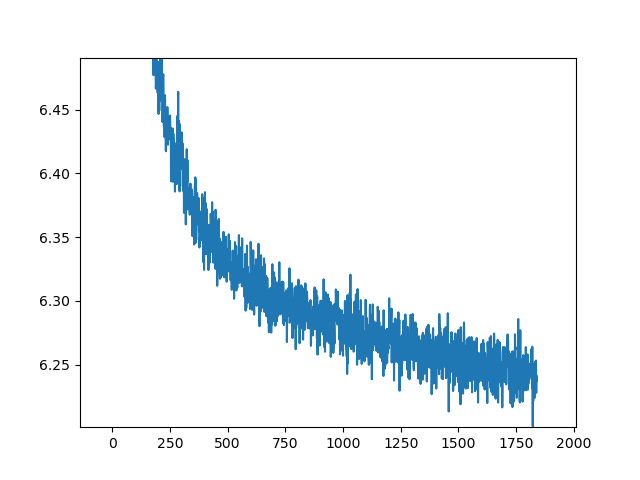

In [20]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.figure()
plt.plot(losses_train)
# plt.yscale('log')

In [21]:
# model.load_state_dict(torch.load('/media/rich/bigSSD/EfficientNet_b0_7unfrozen_simCLR.pth'))
# model.eval()

## Use sklearn to train classifier

In [22]:
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

<IPython.core.display.Javascript object>


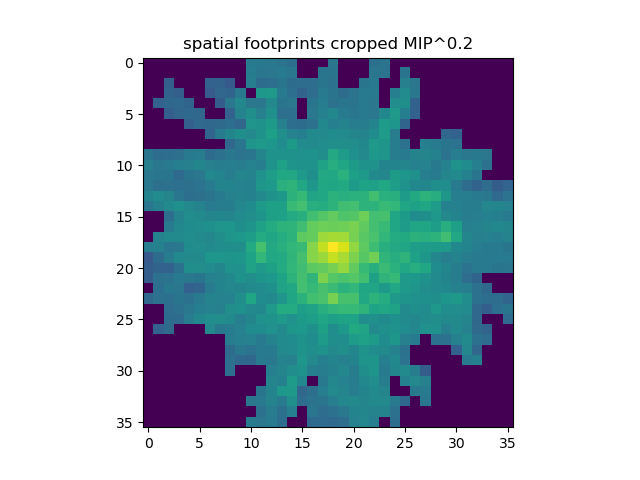

In [23]:
path_stat = r'/media/rich/bigSSD/for_Josh/SimCLR-Label-Data/mouse2_6__20210409/stat.npy'
path_labels = r'/media/rich/bigSSD/for_Josh/SimCLR-Label-Data/mouse2_6__20210409/labels_round2_sesh1.npy'

# path_stat = r'/media/rich/bigSSD/for_Josh/SimCLR-Label-Data/mouse6_28 _ day20200815/stat.npy'
# path_labels = r'/media/rich/bigSSD/for_Josh/SimCLR-Label-Data/mouse6_28 _ day20200815/labels_posthoc_all.npy'


images_labeled = np.concatenate(
    util.import_multiple_stat_files(   
        paths_statFiles=[path_stat],
        out_height_width=[36,36],
        max_footprint_width=241,
        plot_pref=True
    )
)

labels = classification.squeeze_integers(np.concatenate([np.load(path_labels)]))

assert images_labeled.shape[0] == labels.shape[0] , 'num images in stat files does not correspond to num labels'

In [29]:
np.unique(labels)

array([0., 1., 2., 3., 4.])

In [30]:
idx_toKeep = np.where(np.logical_not(labels == 4))[0]

images_labeled_clean = images_labeled[idx_toKeep]
labels_clean = labels[idx_toKeep]

In [31]:
transforms_classifier = torch.nn.Sequential(
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
    
    torchvision.transforms.Resize(
        size=(224, 224),
#         size=(180, 180),
#         size=(72, 72),        
        interpolation=torchvision.transforms.InterpolationMode.BILINEAR), 
    
    augmentation.TileChannels(dim=0, n_channels=3),
)

scripted_transforms_classifier = torch.jit.script(transforms_classifier)


In [32]:
def helper_make_dataset(X):
    out = dataset.dataset_simCLR(
        X=torch.as_tensor(X, device='cpu', dtype=torch.float32),
        y=torch.as_tensor(torch.zeros(X.shape[0]), device='cpu', dtype=torch.float32),
        n_transforms=1,
        class_weights=np.array([1]),
        transform=scripted_transforms_classifier,
        DEVICE='cpu',
        dtype_X=torch.float32,
    )
    return out

def helper_make_dataloader(ds):
    out = torch.utils.data.DataLoader( 
        ds,
        batch_size=128,
        shuffle=False,
        drop_last=False,
#         pin_memory=True,
#         num_workers=36,
#         persistent_workers=True,
#         prefetch_factor=2
    )
    return out

In [33]:
dataset_labeled_clean = helper_make_dataset(images_labeled_clean)
    
dataloader_labeled_clean = helper_make_dataloader(dataset_labeled_clean)

In [34]:
DEVICE = torch_helpers.set_device(use_GPU=True)

device: 'cuda:0'


In [35]:
model.eval()
model.to(DEVICE)
features_nn = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dataloader_labeled_clean], dim=0)

run a sweep of logistic regressions over C (1/L2) parameter

In [36]:
def get_balanced_sample_weights(labels):
    labels = np.int64(labels.copy())
    counts, vals = np.histogram(labels, bins=np.concatenate((np.unique(labels), [labels.max()+1])))
    vals = vals[:-1]

    n_labels = len(labels)
    weights = n_labels / counts
    
    sample_weights = np.array([weights[l] for l in labels])
    
    return sample_weights

In [37]:
from kymatio import Scattering2D

def get_latents_swt(sfs, swt, device_model):
    sfs = torch.as_tensor(np.ascontiguousarray(sfs[None,...]), device=device_model, dtype=torch.float32)
    latents_swt = swt(sfs[None,...]).squeeze()
    latents_swt = latents_swt.reshape(latents_swt.shape[0], -1)
    return latents_swt


device_model = torch_helpers.set_device(use_GPU=True)

scattering = Scattering2D(J=2, L=8, shape=images_labeled_clean[0].shape[-2:])
if device_model != 'cpu':
    scattering = scattering.cuda()

latents_swt = get_latents_swt(images_labeled_clean, scattering.cuda(), device_model).cpu()

device: 'cuda:0'


/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-21.12/lib/python3.8/site-packages/kymatio/frontend/entry.py:20: DeprecationWarning: Torch frontend is currently the default, but NumPy will become the default in the next version.
  warnings.warn("Torch frontend is currently the default, but NumPy will become the default in the next"


In [38]:
import scipy.stats

In [39]:
torch.corrcoef(features_nn.T).shape

torch.Size([128, 128])

<IPython.core.display.Javascript object>


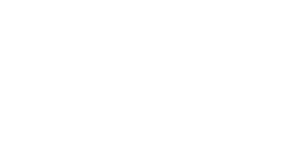

In [40]:
%matplotlib notebook
plt.figure()
plt.imshow(features_nn, aspect='auto',)

<IPython.core.display.Javascript object>


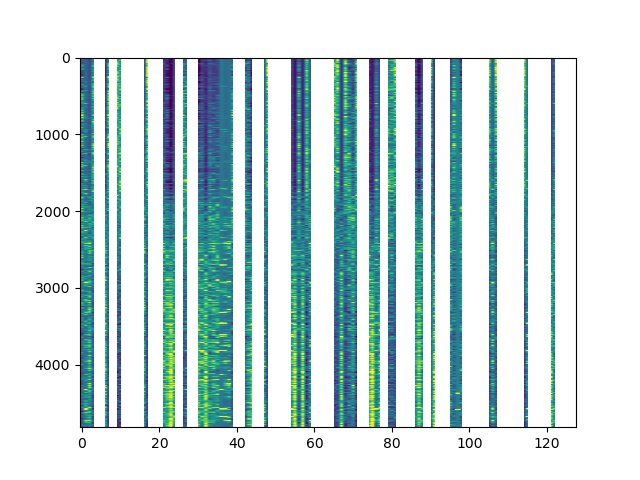

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-21.12/lib/python3.8/site-packages/scipy/stats/stats.py:2553: RuntimeWarning: divide by zero encountered in true_divide
  z = (scores - mn) / std
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-21.12/lib/python3.8/site-packages/scipy/stats/stats.py:2553: RuntimeWarning: invalid value encountered in true_divide
  z = (scores - mn) / std
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-21.12/lib/python3.8/site-packages/scipy/stats/stats.py:2555: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  z[np.broadcast_to(isco

In [41]:
%matplotlib notebook
plt.figure()
plt.imshow(scipy.stats.zscore(features_nn, axis=0), aspect='auto', vmin=-0.8, vmax=1,)

In [42]:
features_nn_z = scipy.stats.zscore(features_nn.numpy(), axis=0)
features_nn_z = features_nn_z[:, ~np.isnan(features_nn_z[0,:])]
features_nn_z = torch.as_tensor(features_nn_z, dtype=torch.float32)

In [43]:
features_nn_z.shape

torch.Size([4815, 74])

In [45]:
comp_nn, scores_nn, SVs, EVR_nn = decomposition.torch_pca(features_nn_z, rank=50, zscore=True)
# comp_nn, scores_nn, SVs, EVR_nn = decomposition.torch_pca(features_nn, rank=60, zscore=True)
comp, scores_swt, SVs, EVR_swt = decomposition.torch_pca(latents_swt, rank=30)
comp, scores_image, SVs, EVR_image = decomposition.torch_pca(images_labeled_clean.reshape(images_labeled_clean.shape[0], -1), rank=5)

<IPython.core.display.Javascript object>


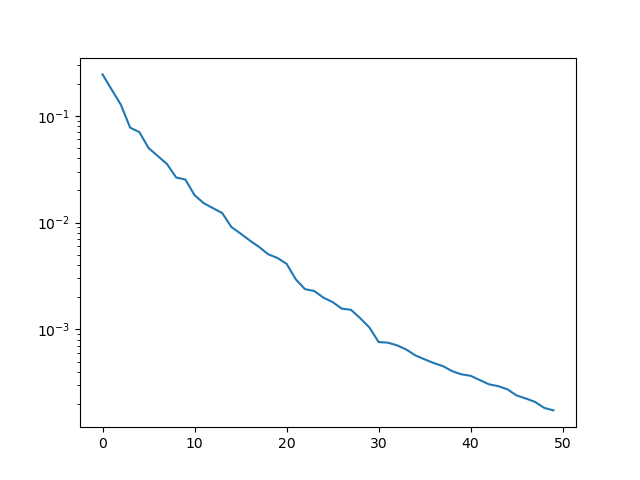

In [46]:
plt.figure()
plt.plot(EVR_nn)
plt.yscale('log')

In [47]:
features_nn.shape

torch.Size([4815, 128])

<IPython.core.display.Javascript object>


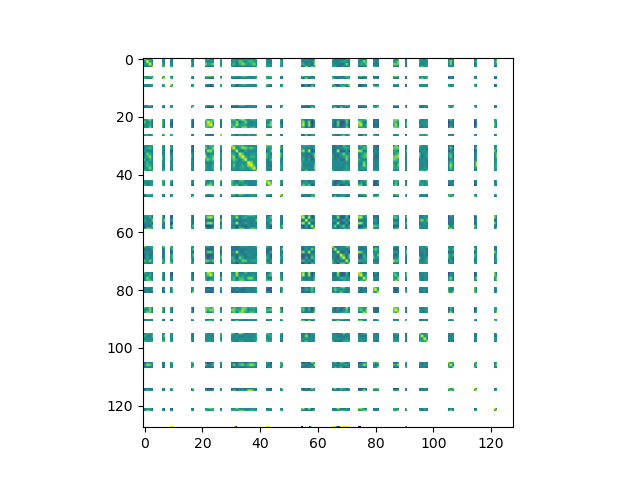

In [48]:
plt.figure()
plt.imshow(torch.corrcoef(features_nn.T))

In [49]:
# comp, features_norm, SVs, EVR = decomposition.torch_pca(features_norm, rank=60)

In [50]:
# comp, features_norm, SVs, EVR = decomposition.torch_pca(features_all, rank=60)

In [51]:
# features_norm = torch.cat([val / torch.std(val) for val in [scores_nn, scores_swt]], dim=1)

In [52]:
features_norm = torch.cat([val / torch.std(val, dim=0).mean() for val in [scores_nn]], dim=1)
# features_norm = torch.cat([val / torch.std(val, dim=0).mean() for val in [scores_swt]], dim=1)
# features_norm = torch.cat([val / torch.std(val, dim=0).mean() for val in [scores_image]], dim=1)
# features_norm = torch.cat([val / torch.std(val, dim=0).mean() for val in [scores_nn, scores_swt]], dim=1)
# features_norm = torch.cat([val / torch.std(val, dim=0).mean() for val in [scores_nn, scores_swt, scores_image]], dim=1)

In [56]:
import sklearn
features_train, features_val, labels_train, labels_val = sklearn.model_selection.train_test_split(features_norm, labels_clean, test_size=0.3)
print(f'train / test shapes: images_labeled_train, images_labeled_val, labels_train, labels_val: {features_train.shape, features_val.shape, labels_train.shape, labels_val.shape}')

train / test shapes: images_labeled_train, images_labeled_val, labels_train, labels_val: (torch.Size([3370, 50]), torch.Size([1445, 50]), (3370,), (1445,))


In [57]:
acc_train, acc_val = [], []
C_toUse = np.array([1000, 100, 10,1,0.1,0.01,0.001])
# C_toUse = np.array([10**-4, 10**-5, 10**-6, 10**-7])
# C_toUse = np.array([10**2, 10**3, 10**4, 10**5])
for C in C_toUse:
    logreg = sklearn.linear_model.LogisticRegression(
        solver='lbfgs',
#         solve='sag'
#         solve='saga'
#         solver='newton-cg',
#         solver='liblinear',
        max_iter=6000, 
        C=C,
        fit_intercept=True, 
        class_weight='balanced',
    #     n_jobs=-1
    )
    logreg.fit(features_train, labels_train)

    acc = logreg.score(features_train, labels_train, sample_weight=get_balanced_sample_weights(labels_train))
    acc_train.append(acc)

    acc = logreg.score(features_val, labels_val, sample_weight=get_balanced_sample_weights(labels_val))
    acc_val.append(acc)
    
    

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-21.12/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


best val score: 0.7946649022636721
best C value: 1000.0


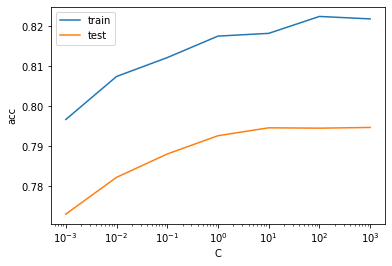

In [61]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(C_toUse, acc_train)
plt.plot(C_toUse, acc_val)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('acc')
plt.legend(['train', 'test']);

print(f'best val score: {max(acc_val)}')
print(f'best C value: {C_toUse[np.argmax(acc_val)]}')

run a sinlg logistic regression with desired parameters and check confusion matrix

In [59]:
logreg = sklearn.linear_model.LogisticRegression(
        solver='lbfgs',
#         solver='sag',
#         solver='saga',
#         solver='newton-cg',
#         solver='liblinear',
    max_iter=8000, 
    C=10**(-1),
    fit_intercept=True, 
    class_weight='balanced',
#     n_jobs=-1
).fit(features_train, labels_train)

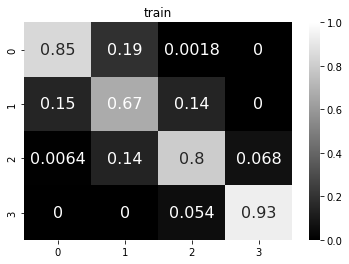

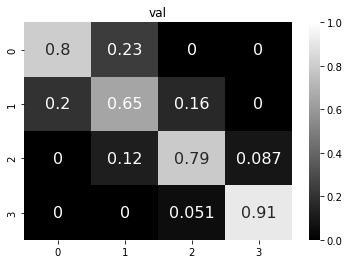

In [60]:
%matplotlib inline
import seaborn as sns

proba = logreg.predict_proba(features_train)
preds = np.argmax(proba, axis=1)

# preds = svm.predict(features_train_norm).astype(np.int32)

cm = classification.confusion_matrix(preds, labels_train.astype(np.int32))

plt.figure()
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
plt.title('train');



proba = logreg.predict_proba(features_val)
preds = np.argmax(proba, axis=1)

# preds = svm.predict(features_val_norm).astype(np.int32)

cm = classification.confusion_matrix(preds, labels_val.astype(np.int32))

plt.figure()
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
plt.title('val');


In [67]:
labels_sesh1 = np.load(r'/media/rich/bigSSD/for_Josh/SimCLR-Label-Data/mouse2_6__20210409/labels_round2_sesh1.npy')
labels_sesh2 = np.load(r'/media/rich/bigSSD/for_Josh/SimCLR-Label-Data/mouse2_6__20210409/labels_round2_sesh2.npy')

<IPython.core.display.Javascript object>


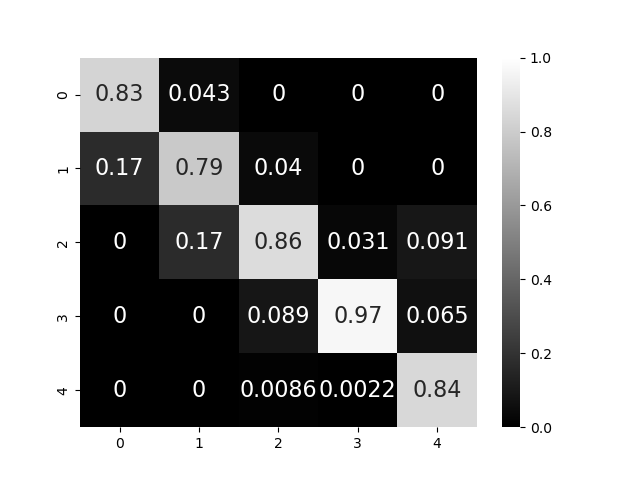

<AxesSubplot:>

In [68]:
plt.figure()
sns.heatmap(
    classification.confusion_matrix(labels_sesh1.astype(np.int32), labels_sesh2.astype(np.int32)),
    annot=True, 
    annot_kws={"size": 16}, 
    vmax=1., 
    cmap=plt.get_cmap('gray')
)

In [ ]:
[(name, params.shape) for name, params in model.state_dict().items()]

In [ ]:
%matplotlib notebook

layer_1 = model.state_dict()['base_model.0.0.0.weight'].cpu()
# layer_2 = model.state_dict()['base_model.0.6.3.block.1.0.weight'].cpu()
# layer_3 = model.state_dict()['base_model.0.7.0.block.1.0.weight'].cpu()
# layer_4 = model.state_dict()['base_model.0.7.0.block.1.0.weight'].cpu()


plotting_helpers.plot_image_grid(torch.cat([arr for arr in layer_1], dim=0), grid_shape=(15,15), kwargs_imshow={'vmax': 0.2});
# plotting_helpers.plot_image_grid(torch.cat([arr for arr in layer_2], dim=0), grid_shape=(6,6), kwargs_imshow={'vmax': 0.2});
# plotting_helpers.plot_image_grid(torch.cat([arr for arr in layer_3], dim=0), grid_shape=(4,6), kwargs_imshow={'vmax': 0.2});


In [63]:
from umap import UMAP

In [64]:
umap = UMAP(
    n_neighbors=30,
    n_components=2,
    metric='euclidean',
    metric_kwds=None,
    output_metric='euclidean',
    output_metric_kwds=None,
    n_epochs=None,
    learning_rate=1.0,
    init='spectral',
    min_dist=0.1,
    spread=1.0,
    low_memory=True,
    n_jobs=-1,
    set_op_mix_ratio=1.0,
    local_connectivity=1.0,
    repulsion_strength=1.0,
    negative_sample_rate=5,
    transform_queue_size=4.0,
    a=None,
    b=None,
    random_state=None,
    angular_rp_forest=False,
    target_n_neighbors=-1,
    target_metric='categorical',
    target_metric_kwds=None,
    target_weight=0.5,
    transform_seed=42,
    transform_mode='embedding',
    force_approximation_algorithm=False,
    verbose=False,
    tqdm_kwds=None,
    unique=False,
    densmap=False,
    dens_lambda=2.0,
    dens_frac=0.3,
    dens_var_shift=0.1,
    output_dens=False,
    disconnection_distance=None,
    precomputed_knn=(None, None, None),
)

In [65]:
embeddings = umap.fit_transform(features_nn)
# embeddings = umap.fit_transform(scores_nn)
# embeddings = umap.fit_transform(latents_swt)
# embeddings = umap.fit_transform(features_norm)

<IPython.core.display.Javascript object>


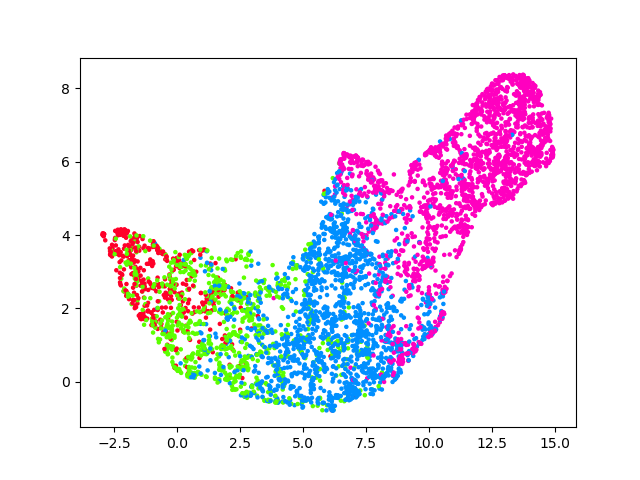

In [66]:
%matplotlib notebook

plt.figure()
plt.scatter(embeddings[:,0], embeddings[:,1], s=5, c=labels_clean, cmap='gist_rainbow')

In [ ]:
%matplotlib notebook

plt.figure()
plt.scatter(scores_nn[:,1], scores_nn[:,0], c=labels_clean)